In [ ]:
import pandas as pd
import umap
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from functions.common_functions import *

In [2]:
df = pd.read_csv('../data/processed/mannich_scope-descriptors.csv')

In [3]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df.iloc[:,5:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

In [22]:
full_df = pd.read_csv('../data/interim/mannich_database_scope.csv')
full_df = remove_x(full_df,'ee')
full_df_trim = full_df.loc[:,['Reaction','Catalyst_Type','ee']]
num_reactions = len(df)

cluster_list = []
cat_list = []
gen_list = []

for neighbour in [15,100,200,300,400,500,600,700,800,900,1000,1100,1200,1293]:
    reducer = umap.UMAP(
        random_state=25,
        min_dist=0,  # Default is 0.1
        n_neighbors=neighbour,  # Default is 15
        n_components=10)
    
    clustering_embedding = reducer.fit_transform(scaled_data)

    labels = k_cluster(clustering_embedding,12)
    rxn_cluster_df = pd.DataFrame({'Reaction':df['Reaction'],'cluster_label':labels})

    full_df_clusters = pd.merge(full_df_trim,rxn_cluster_df,how='inner',on='Reaction')

    cats = full_df_clusters['Catalyst_Type'].unique()
    
    for cat in cats:
        generality, clusters, cluster_ee = calc_generality(full_df_clusters,cat,'Catalyst_Type','ee', full_df_clusters['cluster_label'], 80)
        cat_list.append(cat)
        gen_list.append(generality)
    
    print(str(neighbour) + " Done")

varying_n_neighbour_generality = pd.DataFrame({'catalyst':cat_list,'generality':gen_list})
varying_n_neighbour_generality = varying_n_neighbour_generality.set_index('catalyst')

15 Done
100 Done
200 Done
300 Done
400 Done
500 Done
600 Done
700 Done
800 Done
900 Done
1000 Done
1100 Done
1200 Done
1293 Done


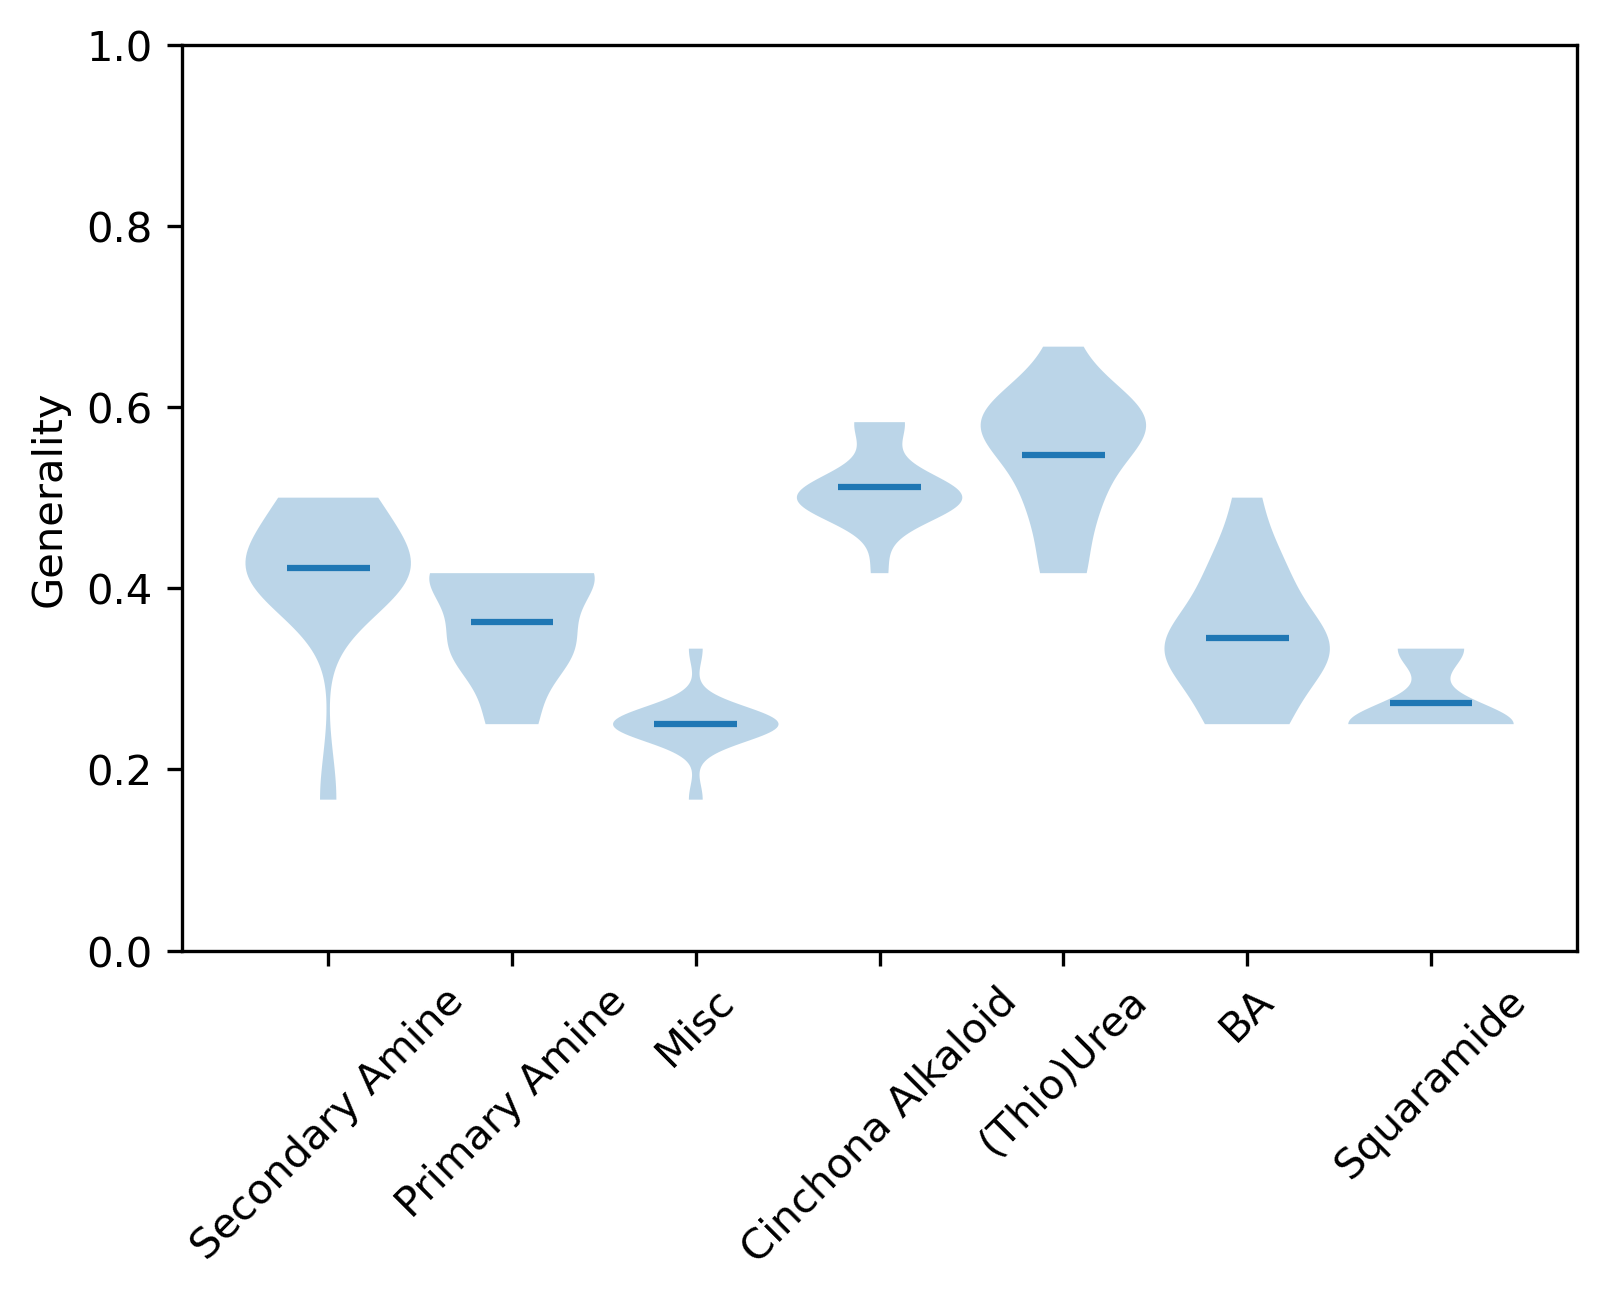

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.violinplot([varying_n_neighbour_generality.loc['Secondary Amine','generality'],varying_n_neighbour_generality.loc['Primary Amine','generality'], varying_n_neighbour_generality.loc['Misc','generality'],
                varying_n_neighbour_generality.loc['Cinchona Alkaloid','generality'], varying_n_neighbour_generality.loc['(Thio)Urea','generality'], varying_n_neighbour_generality.loc['BA','generality'],
                varying_n_neighbour_generality.loc['Squaramide','generality']], showmeans=True, showextrema=False, widths=0.9)
fig.set_dpi(300)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(cats)
plt.xticks(rotation=45)
plt.ylabel('Generality')
plt.ylim(0,1)
plt.show()

In [24]:
import plotly.express as px

for neighbour in [400,1200]:
    reducer = umap.UMAP(
        random_state=25,
        min_dist=0,  # Default is 0.1
        n_neighbors=neighbour,  # Default is 15
        n_components=2)
    
    clustering_embedding = reducer.fit_transform(scaled_data)
    fig = px.scatter(x=clustering_embedding[:,0],y=clustering_embedding[:,1], color=df['Catalyst_Type'], height=400, width=500,
                     template='simple_white', labels={
                     "x": "UMAP1",
                     "y": "UMAP2"},
                     title="num_neighbours = " + str(neighbour))

    fig.update_layout(
        title={
            'y':0.8,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    fig.update_layout(showlegend=True)
    fig.show()
